In [26]:
#!pip install open3d
#!pip install shapely
#!jt -l
#!jt -t chesterish

In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import random
import copy
import os 
import sys
from sklearn import linear_model
import math
from scipy.stats import linregress
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
from shapely.ops import unary_union

pcd = o3d.io.read_point_cloud("miniprojekt.ply")
#pcd = o3d.io.read_point_cloud("projectPLY.ply")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
downpcd = pcd.voxel_down_sample(voxel_size = 0.1)
print(downpcd)
o3d.visualization.draw_geometries([downpcd])

PointCloud with 7780 points.


In [3]:
def NumpyToPCD(xyz):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    return pcd


def PCDToNumpy(pcd):
    return np.asarray(pcd.points)


def DetermineSliceValues(points):
    HighestPoint = np.amax(points[:,1])
    LowestPoint = np.amin(points[:,1])
    x = np.array([LowestPoint, HighestPoint])
    TotalHeight = np.absolute(x)
    TotalHeight = TotalHeight[0] + TotalHeight[1]
    
    sliceHeight = (TotalHeight / 2)
    LowestPoint = LowestPoint + (sliceHeight + 0.5)
    HighestPoint = HighestPoint - (sliceHeight - 0.7)
    x = np.array([LowestPoint, HighestPoint])
    print(x)
    return x
    
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    #print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    #inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    #o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])
    return inlier_cloud      
    

def SlicePoints(points, axis, minimum_value=0.5, maximum_value=1.5):
    
    new_List = []
    for z_value in range(len(points)):
        if points[z_value, axis] >  minimum_value and points[z_value, axis] <  maximum_value:
            new_List.append(points[z_value])
    arr = np.array(new_List)
    pcd = NumpyToPCD(arr)
    #print("After removal of ceiling and floor: ", pcd)
    return pcd



def outlierRemoval(points, neighbors=20, ratio=2.0):
    cl, ind = points.remove_statistical_outlier(nb_neighbors=neighbors, std_ratio=ratio)
    inlier_cloud = display_inlier_outlier(points, ind)
    return inlier_cloud



def collapsAxis(cloud, axis):
    np_cloud = PCDToNumpy(cloud)
    new_List = []
    
    for value in range(len(np_cloud)):
        np_cloud[value, axis] = 0.0
        new_List.append(np_cloud[value])
    pcd = NumpyToPCD(np_cloud)
    return pcd

In [4]:
if __name__ == "__main__":
    points = PCDToNumpy(downpcd)
    MinAndMax = DetermineSliceValues(points)
    plane_points = SlicePoints(points, 1, MinAndMax[0], MinAndMax[1])
    plane_points2 = outlierRemoval(plane_points, neighbors=10, ratio=2.0)
    Two_Dim_Plane = collapsAxis(plane_points2, axis=1)
    o3d.visualization.draw_geometries([Two_Dim_Plane])

[0.56359676 0.76359676]


In [5]:
def solve(bl, tr, p, corner, var=0.3):
    

    if corner == 'minmin':
        if (p[0] <= tr[0] + var and p[0] >= bl[0] - var and p[1] <= bl[1] + var and p[1] >= bl[1] - var
            or p[0] <= bl[0] + var and p[0] >= bl[0] - var and p[1] <= tr[1] + var and p[1] >= bl[1] - var
            or p[0] <= tr[0] + var and p[0] >= tr[0] - var and p[1] <= tr[1] + var and p[1] >= bl[1] - var
            or p[0] <= tr[0] + var and p[0] >= bl[0] - var and p[1] <= tr[1] + var and p[1] >= tr[1] - var
         ): 
            return True
        else :
            return False
    
    if corner == 'minmax':
        if (p[0] <= tr[0] + var and p[0] >= bl[0] - var and p[1] >= bl[1] - var and p[1] <= bl[1] + var
            or p[0] <= bl[0] + var and p[0] >= bl[0] - var and p[1] >= tr[1] - var and p[1] <= bl[1] + var
            or p[0] <= tr[0] + var and p[0] >= tr[0] - var and p[1] >= tr[1] - var and p[1] <= bl[1] + var
            or p[0] <= tr[0] + var and p[0] >= bl[0] - var and p[1] >= tr[1] - var and p[1] <= tr[1] + var
         ): 
            return True
        else :
            return False
    
    if corner == 'maxmax':
        if (p[0] >= tr[0] - var and p[0] <= bl[0] + var and p[1] >= bl[1] - var and p[1] <= bl[1] + var
            or p[0] >= bl[0] - var and p[0] <= bl[0] + var and p[1] >= tr[1] - var and p[1] <= bl[1] + var
            or p[0] >= tr[0] - var and p[0] <= tr[0] + var and p[1] >= tr[1] - var and p[1] <= bl[1] + var
            or p[0] >= tr[0] - var and p[0] <= bl[0] + var and p[1] >= tr[1] - var and p[1] <= tr[1] + var
         ): 
            return True
        else :
            return False
    
    if corner == 'maxmin':
        if (p[0] >= tr[0] - var and p[0] <= bl[0] + var and p[1] <= bl[1] + var and p[1] >= bl[1] - var
            or p[0] >= bl[0] - var and p[0] <= bl[0] + var and p[1] <= tr[1] + var and p[1] >= bl[1] - var
            or p[0] >= tr[0] - var and p[0] <= tr[0] + var and p[1] <= tr[1] + var and p[1] >= bl[1] - var
            or p[0] >= tr[0] - var and p[0] <= bl[0] + var and p[1] <= tr[1] + var and p[1] >= tr[1] - var
         ): 
            return True
        else :
            return False
         
        #bl, tr, p
        #startPoint, oppPoint, point   

In [7]:
#Use RANSAC to find slope of best straight line
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, RANSACRegressor

def FindSlope(X, y):
    ransac = RANSACRegressor(base_estimator=LinearRegression(),
                                 min_samples=2, max_trials=100,
                                 loss='absolute_loss', random_state=0,
                                 residual_threshold=0.15)
    ransac.fit(X, y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    line_X = np.arange(X.min(), X.max())
    line_y_ransac = ransac.predict(line_X.reshape((len(line_X), 1)))
    
    plt.figure(figsize=(20, 15))
    
    plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white',
            marker='o', label='Inliers')
    
    plt.scatter(X[outlier_mask], y[outlier_mask],
             c='limegreen', edgecolor='white',
             marker='s', label='Outliers')
    
    plt.plot(line_X, line_y_ransac, color='black')
    
    slope, intercept, r_value, p_value, std_err = linregress(line_X, line_y_ransac)
    return slope 

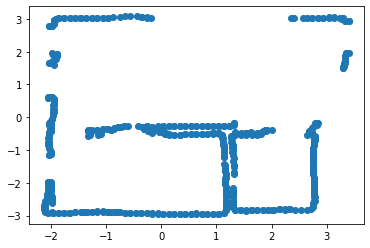

Slope of line:  -0.022566398932785503
angle in Radians: -0.02256256951402306


NameError: name 'rotatingPoints' is not defined

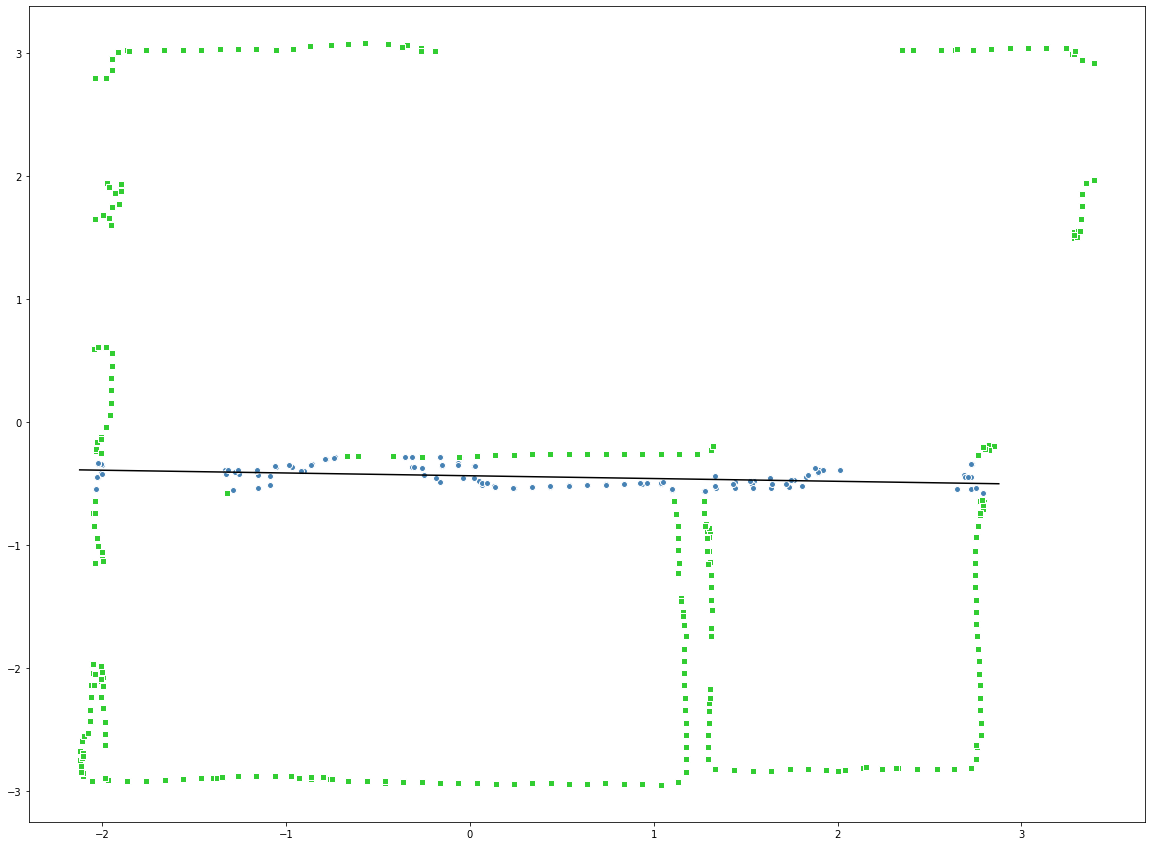

In [8]:
# Take inspiration from above to broaden use cases, but for now not necessary. Use this to find the angle to know what to rotate the points with
def findAng(theta):
    if theta > 1.57:
        theta -= np.pi/2
    else:
        theta =  abs(theta) - np.pi/2
    return theta

pGen = PCDToNumpy(Two_Dim_Plane)
pts = np.delete(pGen, 1, 1)
x = pts[:,0].reshape(-1, 1)
y = pts[:,1]
plt.axes()
x1 = pts[:,0]
y1 = pts[:,1]
plt.scatter(x1,y1)
plt.show()
slope = FindSlope(x, y)
print('Slope of line: ', slope)
angle = np.arctan(slope)
print('angle in Radians:', angle)
if angle > 0.1 or angle < - 0.1:
    angle = findAng(angle)

rotPts = rotatingPoints(points, angle)

   
def rotate(origin, point, angle):
    origin_x, origin_y = origin #Set to be the bottom left corner
    print("herheherehjrehre", point)
    px = point[0]
    py = point[1]
    
    qx = origin_x + math.cos(angle) * (px - origin_x) - math.sin(angle) * (py - origin_y)
    qy = origin_y + math.sin(angle) * (px - origin_x) + math.cos(angle) * (py - origin_y)

    return qx, qy

def rotatingPoints(points, angle):
    origin = (0, 0)
    rotPts = []
    for point in points:
        newPts = rotate(origin, point, angle)
        rotPts.append(newPts)
    
    rotPts = np.array(rotPts)
    return rotPts 








In [9]:
def FindStartPos(points, minLenght=0.55):
    minLenght = 0.55 # maximum distance from point is 1 meter
    startPoint = [0, 0]
    isGood = False
    keepLooking = True
    
    while(keepLooking):
        startPoint = [min(points[:,0]) + 0.1, min(points[:,1]) + 0.1]
        isGood = CalculateDistance(points, startPoint, minLenght)
        if isGood == True:
            return startPoint, "minmin"
        else:
            startPoint = [min(points[:,0]) + 0.1, max(points[:,1]) - 0.1]
            print('second: ', startPoint)
            isGood = CalculateDistance(points, startPoint, minLenght)
            if isGood == True:
                return startPoint, "minmax"
            else:
                startPoint = [max(points[:,0] - 0.1), max(points[:,1]) - 0.1]
                print('third: ', startPoint)
                isGood = CalculateDistance(points, startPoint, minLenght)
                if isGood == True:
                    return startPoint, "maxmax"
                else:
                    startPoint = [max(points[:,0] - 0.1), min(points[:,1]) + 0.1]
                    print('fourth: ', startPoint)
                    isGood = CalculateDistance(points, startPoint, minLenght)
                if isGood == True:
                    return startPoint, "maxmin"
        minLenght += 0.1

        
        
        
        
def CalculateDistance(points, startPoint, minLenght):
    for point in points:
        dist = np.linalg.norm(startPoint - point)
        if dist < minLenght:
            print('minLenght is smaller: ', dist)
            return True
    print('minLenght is bigger \n\n')
    return False



def cornerCorrections(string, startPoint):
    oppPoint = [startPoint[0], startPoint[1]]
    distanceToTravelX = 0
    distanceToTravelY = 0
    
    if string == 'minmin':
        oppPoint = [startPoint[0]+1, startPoint[1]+1]
        distanceToTravelX = 0.1
        distanceToTravelY = 0.1
        print('minmin')
        
    if string == 'minmax':
        oppPoint = [startPoint[0]+1, startPoint[1]-1]
        distanceToTravelX = 0.1
        distanceToTravelY = -0.1
        print('minmax')
        
    if string == 'maxmax':
        oppPoint = [startPoint[0]-1, startPoint[1]-1]
        distanceToTravelX = -0.1
        distanceToTravelY = -0.1
        print('maxmax')
        
    if string == 'maxmin':
        oppPoint = [startPoint[0]-1, startPoint[1]+1]
        distanceToTravelX = -0.1
        distanceToTravelY = 0.1
        print('maxmin')
    return oppPoint, distanceToTravelX, distanceToTravelY


def checkIfInsideSquare(startPoint, oppPoint, point, string):
    if string == 'minmin':
       if (point[0] >= startPoint[0] and point[0] <= oppPoint[0] and
           point[1] >= startPoint[1] and point[1] <= oppPoint[1]):
          return True
       else:
          return False
        
    if string == 'minmax':
       if (point[0] >= startPoint[0] and point[0] <= oppPoint[0] and
           point[1] <= startPoint[1] and point[1] >= oppPoint[1]):
          return True
       else:
          return False
        
    if string == 'maxmax':
       if (point[0] >= startPoint[0] and point[0] <= oppPoint[0] and
           point[1] <= startPoint[1] and point[1] >= oppPoint[1]):
          return True
       else:
          return False
        
    if string == 'maxmin':
       if (point[0] <= startPoint[0] and point[0] >= oppPoint[0] and
           point[1] >= startPoint[1] and point[1] <= oppPoint[1]):
          return True
       else:
          return False

def removeInliers(startPos, endPos, rotPts, string):
    newPointCloud = []
    finalPointCloud = []
    for point in rotPts:
        checkPoint = solve(startPos, endPos, point, string, var=0.15)
        if checkPoint == False:
            newPointCloud.append(point)
    
    
    for point in newPointCloud:
        checkPoint = checkIfInsideSquare(startPos, endPos, point, string)
        if checkPoint == False:
            finalPointCloud.append(point)
    return np.asarray(finalPointCloud)

In [10]:
def boxGen(points): 
    startPoint, string = FindStartPos(points)
    oppPoint, distanceToTravelX, distanceToTravelY = cornerCorrections(string, startPoint)
    #Check previous value
    coords = [0, 0]
    preVal = []
    Inliers = 0
    Outliers = 0
    keepGoingX = True
    keepGoingY = True
    
    #While the x axis is less than the maximum x point 
    while keepGoingX == True:
        for point in points:
            checkPoint = solve(startPoint, oppPoint, point, string, 0.15)
            if checkPoint == True:
                Inliers += 1    
            else:
                Outliers += 1
        
        preVal.append(Inliers)
        if len(preVal) > 1:
            if preVal[-2] > Inliers+5:
                keepGoingX = False
                oppPoint[0] -= distanceToTravelX
                coords[0] = oppPoint[0]
                print('Largest X: ', preVal[-2])
                
            if len(preVal) > 50:
                if preVal[-50] == Inliers:
                    keepGoingX = False
                    oppPoint[0] -= distanceToTravelX*50
                    coords[0] = oppPoint[0]
        
        oppPoint[0] += distanceToTravelX 
        print("Current inliers X: ", Inliers)
        print(oppPoint[0])
        Inliers = 0
        
    #Move the y-axis a little before starting the iteration there in order to avoid getting the same value for the start of the next one
    oppPoint[1] += distanceToTravelY
    preVal = []
    while keepGoingY == True:
        for point in points:
            checkPoint = solve(startPoint, oppPoint, point, string, 0.15)
            if checkPoint == True:
                Inliers += 1
            else:
                Outliers += 1
                
        preVal.append(Inliers)
        if len(preVal) > 1:
            if preVal[-2] > Inliers+5:
                keepGoingY = False
                oppPoint[1] -= distanceToTravelY
                coords[1] = oppPoint[1]
                print('Largest Y: ', preVal[-2])
            if len(preVal) > 50:
                if preVal[-50] == Inliers:
                    print('here!!', oppPoint[1])
                    keepGoingY = False
                    oppPoint[1] -= distanceToTravelY*50
                    print('after!!', oppPoint[1])
                    coords[1] = oppPoint[1]
        
        oppPoint[1] += distanceToTravelY 
        print("Current inliers Y: ", Inliers)
        print(oppPoint[1])
        Inliers = 0
    print('DONE \n\n\n\n\n')
    return startPoint, coords, string




In [11]:
startBoxes = []
endBoxes = []
stringTag = []

if angle < 0.1 or angle > - 0.1:
    rotPts = pts
    


new_rotPts = rotPts
for i in range(3):
    startPos, endPos, string = boxGen(new_rotPts)
    startBoxes.append(startPos)
    endBoxes.append(endPos)
    stringTag.append(string)
    new_rotPts = removeInliers(startPos, endPos, new_rotPts, string)



minLenght is smaller:  0.46573693266994526
minmin
Current inliers X:  70
-0.9231488600000001
Current inliers X:  75
-0.8231488600000001
Current inliers X:  77
-0.7231488600000001
Current inliers X:  79
-0.6231488600000001
Current inliers X:  81
-0.5231488600000002
Current inliers X:  83
-0.4231488600000002
Current inliers X:  85
-0.3231488600000002
Current inliers X:  87
-0.2231488600000002
Current inliers X:  89
-0.1231488600000002
Current inliers X:  91
-0.023148860000000188
Current inliers X:  93
0.07685113999999982
Current inliers X:  95
0.17685113999999982
Current inliers X:  97
0.27685113999999983
Current inliers X:  99
0.37685113999999986
Current inliers X:  101
0.47685113999999984
Current inliers X:  103
0.5768511399999998
Current inliers X:  105
0.6768511399999998
Current inliers X:  107
0.7768511399999998
Current inliers X:  109
0.8768511399999998
Current inliers X:  111
0.9768511399999997
Current inliers X:  113
1.0768511399999998
Current inliers X:  139
1.17685114
Current i

In [12]:
from matplotlib.pyplot import figure

def DrawFloorPlan(startPoints, endPoints, new_rotPts):
    rect = [-3, -3, 1, 1.5]
     #plt.axes()]
    plt.axes(rect)
    for i in range(len(startPoints)):
        startPoint = startPoints[i]
        endPoint = endPoints[i]
        startx = 0
        starty = 0
        if startPoint[0] > endPoint[0]:
            startx = endPoint[0]
        else:
            startx = startPoint[0]
        if startPoint[1] > endPoint[1]:
            starty = endPoint[1]
        else:
            starty = startPoint[1]
            
        rectangle = plt.Rectangle((startx, starty), abs(startPoint[0] - endPoint[0]), abs(startPoint[1] - endPoint[1]), fc='none',ec="red")
        plt.gca().add_patch(rectangle)
    x = new_rotPts[:,0]
    y = new_rotPts[:,1]
    plt.scatter(x,y)
    plt.show()

[(-1.9497167647727283, -2.84696955988372), (-1.9497167647727283, 2.9816194391304363), (1.27685114, -2.84696955988372)] 
 [(1.27685114, -0.5183805608695644), (3.15028323522726, -0.5183805608695644), (2.835924271823204, -0.5183805608695644)]


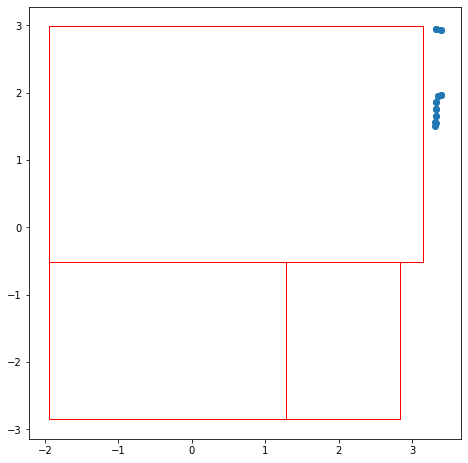

In [20]:

print(startBoxes, "\n" , endBoxes)

#startBoxes = [(-1.9497167647727283, -2.84696955988372), (-1.9497167647727283, 2.9816194391304363), (1.27685114, -2.84696955988372)]
#endBoxes = [(1.27685114, -0.5183805608695644), (3.15028323522726, -0.5183805608695644), (2.835924271823204, -0.5183805608695644)]           

DrawFloorPlan(startBoxes, endBoxes, new_rotPts)
#DrawFloorPlan(new_startBoxes, new_endBoxes, new_rotPts)


In [21]:
print(abs(-2.84696955988372--0.5183805608695644))

2.3285889990141557


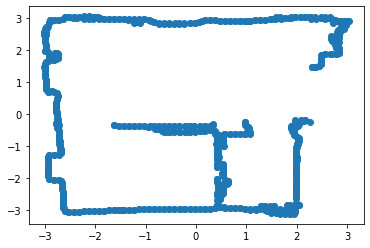

In [45]:
plt.axes()
x = rotPts[:,0]
y = rotPts[:,1]
plt.scatter(x,y)
plt.show()

In [32]:
def findClose(linesX, linesY, val):
    correctedLines = []
    closeLinesX = []
    closeLinesY = []
    
    #Find forskel i y for x linjer og forskel i x for y linjer. Px for forskel i y og vice versa.
    Px = []
    Py = []
    
    
    #Making points
    if len(linesX) > 0:
        for i in range(len(linesX)):
            P1 = Point(linesX[i].coords[0])
            P2 = Point(linesX[i].coords[1])
            Px.append(P1.y)  
            
    #Lokking for lines within buffer
    for i in range(len(linesX)):
        print(linesX[i])
        for j in range(i + 1, len(linesX)):
            if abs(Px[i] - Px[j]) < val:
                closeLinesX.append(linesX[i])
                closeLinesX.append(linesX[j])
                
                
    #Concat lines
        if len(closeLinesX) > 0:
            fixedLinesX = concatLines(closeLinesX)
            for lines in fixedLinesX:
                if lines not in correctedLines:
                    correctedLines.append(lines)
    
    for lines in linesX:
        if lines not in closeLinesX:
                correctedLines.append(lines)
    
    print("Important prints - X")
    print(len(closeLinesX))
    print(len(fixedLinesX))
    print(" ")
    
    if len(linesY) > 0:
        for i in range(len(linesY)):
            P1 = Point(linesY[i].coords[0])
            P2 = Point(linesY[i].coords[1])
            Py.append(P1.x)

    for i in range(len(linesY)):
        for j in range(i + 1, len(linesY)):
            if abs(Py[i] - Py[j]) < val:  
                closeLinesY.append(linesY[i])
                closeLinesY.append(linesY[j])
            
        
        #Concat lines
        if len(closeLinesY) > 0:
            fixedLinesY = concatLines(closeLinesY)
            for lines in fixedLinesY:
                if lines not in correctedLines:
                    correctedLines.append(lines)

    for lines in linesY:
        if lines not in closeLinesY:
            correctedLines.append(lines)
    
    
    return correctedLines, closeLinesY, fixedLinesY

In [20]:
def concatLines(lines):
    longest = 0
    longestLine = []
    
    #Find longest line
    for line in lines:
        if longest < line.length:
            longest = line.length
            longestLine = line
            
    #Find axis
    axis = ''
    first = Point(longestLine.coords[0])
    second = Point(longestLine.coords[1])
    if first.x == second.x:
        axis = 'x'
    elif first.y == second.y:
        axis = 'y'
    else:
        axis = 'unknown'
        
    #Combine all lines
    newLines = []
    for line in lines:
        p1 = Point(line.coords[0])
        p2 = Point(line.coords[1])
        if axis == 'x':
            newP1 = Point(first.x, p1.y)
            newP2 = Point(first.x, p2.y)
            newLine = LineString([newP1, newP2])
            newLines.append(newLine)
                  
        if axis == 'y':
            newP1 = Point(p1.x, first.y)
            newP2 = Point(p2.x, first.y)
            newLine = LineString([newP1, newP2])
            newLines.append(newLine)
    
    return newLines

In [22]:
def lineMaker(sp, ep):
    #sp = startingpoints, ep = endpoints
    p1 = (sp[0],sp[1])
    p2 = (sp[0], ep[1])
    p3 = (ep[0], ep[1])
    p4 = (ep[0], sp[1])
    p5 = (sp[0],sp[1])
    
    linex = LineString([p1, p4])
    lineX = LineString([p2, p3])
    liney = LineString([p1, p2])
    lineY = LineString([p4, p3])

    linesX.append(linex)
    linesX.append(lineX)
    linesY.append(liney)
    linesY.append(lineY)

In [33]:

linesX = []
linesY = []

i = 0
while i < len(startBoxes):
    lineMaker(startBoxes[i], endBoxes[i])
    i += 1


CorrectedLines, y, fy = findClose(linesX, linesY, 0.3)


LINESTRING (-2.02314886 -2.84696955988372, 1.27685114 -2.84696955988372)
LINESTRING (-2.02314886 -0.3469695598837194, 1.27685114 -0.3469695598837194)
LINESTRING (-1.9497167647727283 2.9816194391304363, 3.15028323522726 2.9816194391304363)
LINESTRING (-1.9497167647727283 -0.5183805608695644, 3.15028323522726 -0.5183805608695644)
LINESTRING (1.5359242718232033 -2.744366784, 2.835924271823204 -2.744366784)
LINESTRING (1.5359242718232033 -0.644366783999998, 2.835924271823204 -0.644366783999998)
Important prints - X
8
8
 
Important prints - Y
4
4
 


In [1]:
for i in range(len(y)):
    print(y[i])

lol = unary_union(CorrectedLines)
lol

NameError: name 'y' is not defined